In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

  2%|▏         | 9.00M/395M [00:00<00:04, 86.0MB/s]

100%|██████████| 395M/395M [00:02<00:00, 202MB/s]


In [1]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['60314_2018.jpg', '32076_2010.jpg', '26077_2009.jpg', '847_2000.jpg', '48108_2014.jpg', '31053_2010.jpg', '6732_2003.jpg', '36159_2011.jpg', '11543_2005.jpg', '42131_2013.jpg']


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


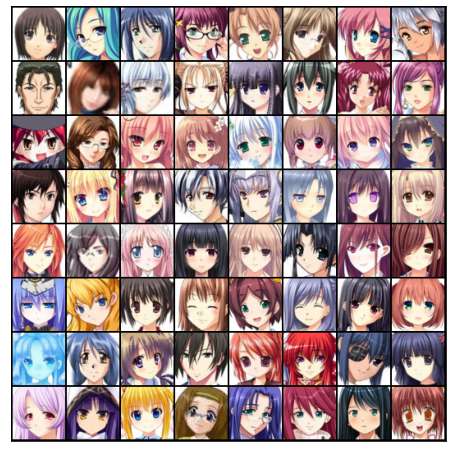

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [14]:
import torch.nn as nn

In [15]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator, device)

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

torch.Size([128, 3, 64, 64])


As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [20]:
generator = to_device(generator, device)

In [21]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [27]:
save_samples(0, fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 50

In [31]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/50], loss_g: 4.3370, loss_d: 0.4397, real_score: 0.8394, fake_score: 0.2011
Saving generated-images-0001.png



Epoch [2/50], loss_g: 5.0020, loss_d: 0.4604, real_score: 0.8601, fake_score: 0.2061
Saving generated-images-0002.png



Epoch [3/50], loss_g: 6.2469, loss_d: 0.3923, real_score: 0.9362, fake_score: 0.2489
Saving generated-images-0003.png



Epoch [4/50], loss_g: 4.6299, loss_d: 0.2521, real_score: 0.8464, fake_score: 0.0605
Saving generated-images-0004.png



Epoch [5/50], loss_g: 8.1258, loss_d: 0.4207, real_score: 0.9900, fake_score: 0.2902
Saving generated-images-0005.png



Epoch [6/50], loss_g: 6.7538, loss_d: 0.2961, real_score: 0.7891, fake_score: 0.0033
Saving generated-images-0006.png



Epoch [7/50], loss_g: 6.0039, loss_d: 0.1506, real_score: 0.9360, fake_score: 0.0672
Saving generated-images-0007.png



Epoch [8/50], loss_g: 5.0093, loss_d: 0.4394, real_score: 0.7521, fake_score: 0.0013
Saving generated-images-0008.png



Epoch [9/50], loss_g: 6.5286, loss_d: 0.1138, real_score: 0.9694, fake_score: 0.0648
Saving generated-images-0009.png



Epoch [10/50], loss_g: 9.5887, loss_d: 0.0434, real_score: 0.9640, fake_score: 0.0041
Saving generated-images-0010.png



Epoch [11/50], loss_g: 10.5432, loss_d: 0.3169, real_score: 0.8195, fake_score: 0.0012
Saving generated-images-0011.png



Epoch [12/50], loss_g: 6.3246, loss_d: 0.1272, real_score: 0.9468, fake_score: 0.0553
Saving generated-images-0012.png



Epoch [13/50], loss_g: 6.2199, loss_d: 0.0907, real_score: 0.9763, fake_score: 0.0535
Saving generated-images-0013.png



Epoch [14/50], loss_g: 6.5183, loss_d: 0.0730, real_score: 0.9718, fake_score: 0.0375
Saving generated-images-0014.png



Epoch [15/50], loss_g: 6.8733, loss_d: 0.0504, real_score: 0.9904, fake_score: 0.0383
Saving generated-images-0015.png



Epoch [16/50], loss_g: 6.1831, loss_d: 0.0456, real_score: 0.9843, fake_score: 0.0272
Saving generated-images-0016.png



Epoch [17/50], loss_g: 7.2693, loss_d: 0.1313, real_score: 0.9369, fake_score: 0.0391
Saving generated-images-0017.png



Epoch [18/50], loss_g: 7.5732, loss_d: 0.0880, real_score: 0.9658, fake_score: 0.0413
Saving generated-images-0018.png



Epoch [19/50], loss_g: 15.9412, loss_d: 0.2994, real_score: 0.9930, fake_score: 0.2297
Saving generated-images-0019.png



Epoch [20/50], loss_g: 6.6238, loss_d: 0.0663, real_score: 0.9583, fake_score: 0.0183
Saving generated-images-0020.png



Epoch [21/50], loss_g: 7.3272, loss_d: 0.0529, real_score: 0.9803, fake_score: 0.0309
Saving generated-images-0021.png



Epoch [22/50], loss_g: 6.1983, loss_d: 0.0952, real_score: 0.9776, fake_score: 0.0631
Saving generated-images-0022.png



Epoch [23/50], loss_g: 12.7899, loss_d: 0.0651, real_score: 0.9889, fake_score: 0.0464
Saving generated-images-0023.png



Epoch [24/50], loss_g: 5.4280, loss_d: 0.1043, real_score: 0.9468, fake_score: 0.0360
Saving generated-images-0024.png



Epoch [25/50], loss_g: 5.0245, loss_d: 0.0700, real_score: 0.9691, fake_score: 0.0294
Saving generated-images-0025.png



Epoch [26/50], loss_g: 9.7733, loss_d: 0.0061, real_score: 0.9987, fake_score: 0.0047
Saving generated-images-0026.png



Epoch [27/50], loss_g: 18.1066, loss_d: 0.2514, real_score: 0.9909, fake_score: 0.1510
Saving generated-images-0027.png



Epoch [28/50], loss_g: 5.6478, loss_d: 0.0337, real_score: 0.9926, fake_score: 0.0253
Saving generated-images-0028.png



Epoch [29/50], loss_g: 4.4283, loss_d: 0.0854, real_score: 0.9532, fake_score: 0.0224
Saving generated-images-0029.png



Epoch [30/50], loss_g: 5.2415, loss_d: 0.1146, real_score: 0.9120, fake_score: 0.0047
Saving generated-images-0030.png



Epoch [31/50], loss_g: 5.5472, loss_d: 0.1214, real_score: 0.9466, fake_score: 0.0368
Saving generated-images-0031.png



Epoch [32/50], loss_g: 4.9705, loss_d: 0.0634, real_score: 0.9641, fake_score: 0.0221
Saving generated-images-0032.png



Epoch [33/50], loss_g: 7.0695, loss_d: 0.0359, real_score: 0.9953, fake_score: 0.0301
Saving generated-images-0033.png



Epoch [34/50], loss_g: 6.5500, loss_d: 0.0462, real_score: 0.9935, fake_score: 0.0377
Saving generated-images-0034.png



Epoch [35/50], loss_g: 7.1144, loss_d: 0.0600, real_score: 0.9704, fake_score: 0.0234
Saving generated-images-0035.png



Epoch [36/50], loss_g: 7.6733, loss_d: 0.0980, real_score: 0.9802, fake_score: 0.0713
Saving generated-images-0036.png



Epoch [37/50], loss_g: 7.6145, loss_d: 0.0207, real_score: 0.9991, fake_score: 0.0190
Saving generated-images-0037.png



Epoch [38/50], loss_g: 6.7137, loss_d: 0.0529, real_score: 0.9767, fake_score: 0.0199
Saving generated-images-0038.png



Epoch [39/50], loss_g: 5.9241, loss_d: 0.0210, real_score: 0.9859, fake_score: 0.0055
Saving generated-images-0039.png



Epoch [40/50], loss_g: 5.8584, loss_d: 0.0368, real_score: 0.9770, fake_score: 0.0066
Saving generated-images-0040.png



Epoch [41/50], loss_g: 8.9325, loss_d: 0.0642, real_score: 0.9787, fake_score: 0.0353
Saving generated-images-0041.png



Epoch [42/50], loss_g: 11.6548, loss_d: 0.0451, real_score: 0.9662, fake_score: 0.0005
Saving generated-images-0042.png



Epoch [43/50], loss_g: 6.6075, loss_d: 0.0694, real_score: 0.9552, fake_score: 0.0018
Saving generated-images-0043.png



Epoch [44/50], loss_g: 9.9250, loss_d: 0.0405, real_score: 0.9676, fake_score: 0.0008
Saving generated-images-0044.png



Epoch [45/50], loss_g: 7.3494, loss_d: 0.0602, real_score: 0.9970, fake_score: 0.0535
Saving generated-images-0045.png



Epoch [46/50], loss_g: 10.4929, loss_d: 0.0297, real_score: 0.9868, fake_score: 0.0142
Saving generated-images-0046.png



Epoch [47/50], loss_g: 6.7253, loss_d: 0.0455, real_score: 0.9870, fake_score: 0.0296
Saving generated-images-0047.png



Epoch [48/50], loss_g: 6.8686, loss_d: 0.0206, real_score: 0.9887, fake_score: 0.0081
Saving generated-images-0048.png



Epoch [49/50], loss_g: 6.6502, loss_d: 0.0291, real_score: 0.9896, fake_score: 0.0169
Saving generated-images-0049.png



Epoch [50/50], loss_g: 8.6380, loss_d: 0.0495, real_score: 0.9709, fake_score: 0.0008
Saving generated-images-0050.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = history

In [33]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [34]:
from IPython.display import Image

In [35]:
Image('./generated/generated-images-0001.png')

In [36]:
Image('./generated/generated-images-0005.png')

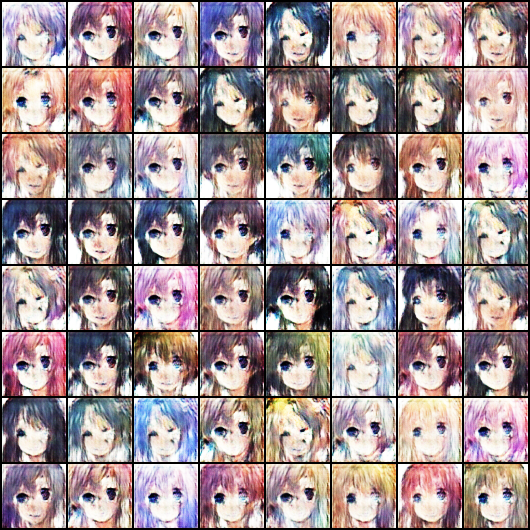

In [37]:
Image('./generated/generated-images-0010.png')

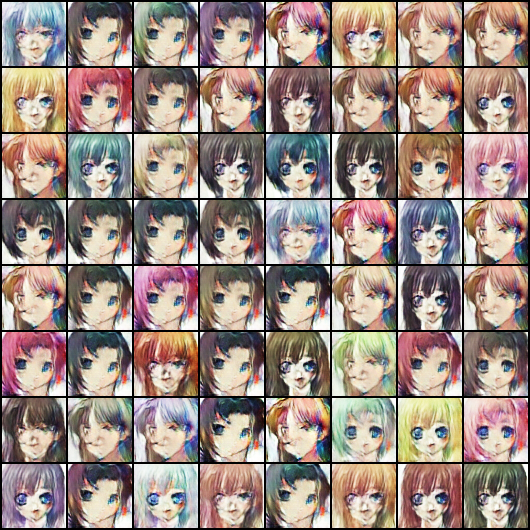

In [43]:
Image('./generated/generated-images-0030.png')

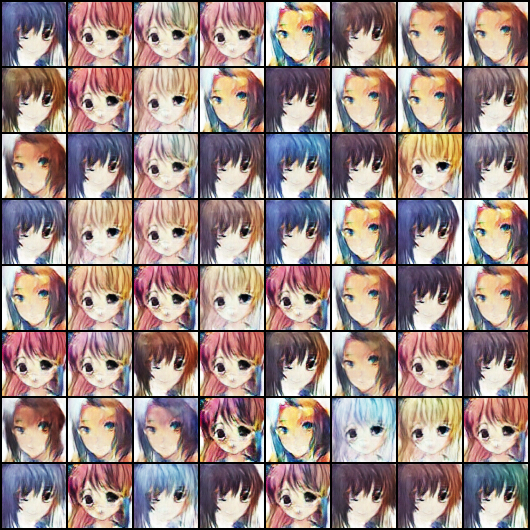

In [44]:
Image('./generated/generated-images-0050.png')

In [40]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

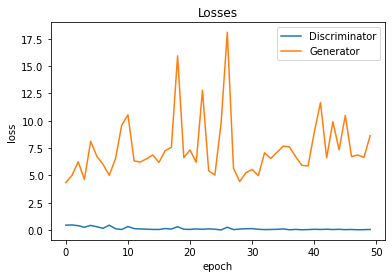

In [41]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

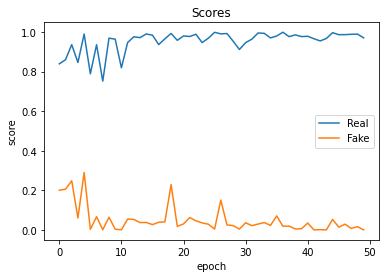

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');